In [ ]:
# Some data-handling functions to download/import.

# from https://github.com/yandexdataschool/mlhep2018/blob/master/day2-Tue/seminar-03-keras-cnn/seminar_tf_keras.ipynb
"""I load some cifar"""

import numpy as np
from sklearn.model_selection import train_test_split
import os, sys
if sys.version_info[0] == 2:
    from urllib import urlretrieve
    import cPickle as pickle

else:
    from urllib.request import urlretrieve
    import pickle

def unpickle(file):
    fo = open(file, 'rb')
    if sys.version_info[0] == 2:
        dict = pickle.load(fo)
    else:
        dict = pickle.load(fo,encoding='latin1')

    fo.close()
    return dict


def download_cifar10(path,
                     url='https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
                     tarname='cifar-10-python.tar.gz',):
    import tarfile
    if not os.path.exists(path):
        os.mkdir(path)



    urlretrieve(url, os.path.join(path,tarname))
    tfile = tarfile.open(os.path.join(path,tarname))
    tfile.extractall(path=path)


def load_cifar10(data_path=".",channels_last=False,test_size=0.2,random_state=1337):

    test_path = os.path.join(data_path,"cifar-10-batches-py/test_batch")
    train_paths = [os.path.join(data_path,"cifar-10-batches-py/data_batch_%i"%i) for i in range(1,6)]

    if not os.path.exists(test_path) or not all(list(map(os.path.exists, train_paths))):
        print ("Dataset not found. Downloading...")
        download_cifar10(data_path)

    train_batches = list(map(unpickle,train_paths))
    test_batch = unpickle(test_path)

    X = np.concatenate([batch["data"] for batch in train_batches]).reshape([-1,3,32,32]).astype('float32')/255
    y = np.concatenate([batch["labels"] for batch in train_batches]).astype('int32')
    X_train,X_val,y_train,y_val = train_test_split(X,y,
                                                   test_size=test_size,
                                                   random_state=random_state)

    X_test = test_batch["data"].reshape([-1,3,32,32]).astype('float32')/255
    y_test = np.array(test_batch["labels"]).astype('int32')

    if channels_last:
        #convert from [batch,3,H,W] to [batch,H,W,3]
        #WARNING! Make this is only necessary for tensorflow-style dim order
        #If you use theano-style dimensions in keras config, skip this cell
        X_train = X_train.transpose([0,2,3,1])
        X_val   = X_val.transpose([0,2,3,1])
        X_test  = X_test.transpose([0,2,3,1])


    return X_train,y_train,X_val,y_val,X_test,y_test

In [ ]:
import tensorflow as tf
#gpu_options = tf.GPUOptions(allow_growth=True, per_process_gpu_memory_fraction=0.1) # restricts GPU load for multi-user nodes

import tensorflow.keras as keras
from keras import backend as K
import tensorflow as tf
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
print(tf.__version__)

2.15.0


In [ ]:
# Loading the data samples

x_train,y_train,x_val,y_val,x_test,y_test = load_cifar10("cifar_data",channels_last=True)

NUM_CLASSES = 10
cifar10_classes = ["Airplane", "Automobile", "Bird", "Cat", "Deer",
                   "Dog", "Frog", "Horse", "Ship", "Truck"]

print("Train Samples:", x_train.shape, y_train.shape)
print("Test Samples:", x_test.shape, y_test.shape)
print("Val Samples:", x_val.shape, y_val.shape)

Dataset not found. Downloading...
Train Samples: (40000, 32, 32, 3) (40000,)
Test Samples: (10000, 32, 32, 3) (10000,)
Val Samples: (10000, 32, 32, 3) (10000,)


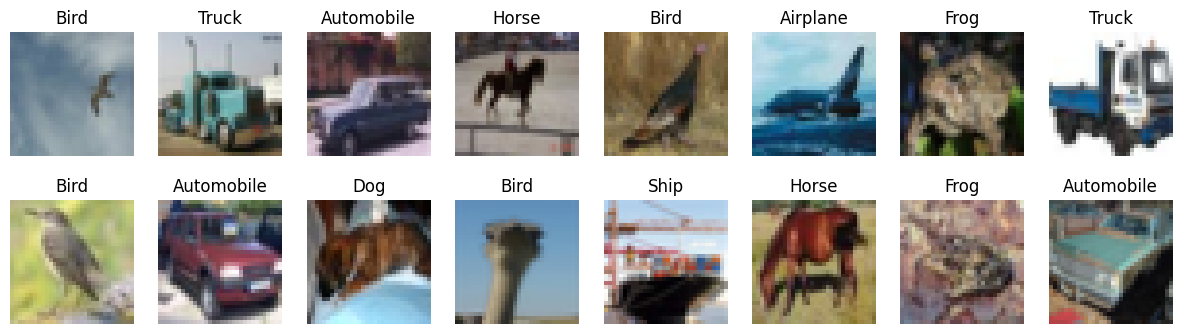

In [ ]:
# show some random images from train, and their labels

cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_train))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_train[random_index, :])
        ax.set_title(cifar10_classes[y_train[random_index]])
plt.show()

In [ ]:
# normalize inputs
# convert class labels to one-hot encoded, should have shape (?, NUM_CLASSES)
# x_train = x_train.astype(np.float64) - 0.5

y_train = keras.utils.to_categorical(y_train, num_classes=10)

y_val = keras.utils.to_categorical(y_val, num_classes=10)

y_test = keras.utils.to_categorical(y_test, num_classes=10)

In [ ]:
# import necessary building blocks
from keras.models import Sequential
from keras.layers import MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout, Input, Conv2D, Activation
import tensorflow as tf

In [ ]:
def my_model():
    """
    Creating a CNN architecture for image classification. This model is based on the CIFAR-10 dataset.
    Upon researching, I found that the images in the CIFAr-10 dataset have shape 32 x 32 with three channels (RGB).
    Multiple convolutional layers, batch normalization, pooling, dropout, and dense layers are enorporated to strenghten the model's learning abilities.
    A few components of the model were aided by consulting ChatGPT and Google.

    """

    model = Sequential([
        # Input layer that augments the data by randomly flipping images horizontally to increase dataset diversity.
        keras.layers.RandomFlip("horizontal", input_shape=(32, 32, 3)),

        # Convolutional Block 1: Consists of two convolutional layers with ReLU activation followed by batch normalization
        # to speed up training and a max pooling layer to reduce spatial dimensions.
        Conv2D(48, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        Conv2D(48, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),  # Dropout to reduce overfitting by randomly setting input units to 0 during training

        # Convolutional Block 2: Increases the number of filters to capture more complex features.
        Conv2D(96, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        Conv2D(96, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.35),  # Increased dropout rate for further regularization

        # Flattening the 3D output to 1D followed by dense layers for classification.
        Flatten(),
        Dense(128, activation='relu'),  # First dense layer
        BatchNormalization(),
        Dropout(0.5),  # Higher dropout rate before the final classification layer
        Dense(10)  # Output layer with 10 units for 10 classes
    ])

    # Adding a final softmax activation separately to ensure clear interpretability
    # of the model's outputs as probabilities for each class. Recommended by ChatGPT.
    model.add(Activation('softmax'))

    return model

# Creating the model.
model = my_model()

# Summary of the model to inspect its architecture and number of parameters.
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, 32, 32, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 48)        1344      
                                                                 
 batch_normalization (Batch  (None, 32, 32, 48)        192       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 48)        20784     
                                                                 
 batch_normalization_1 (Bat  (None, 30, 30, 48)        192       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 48)        0

In [ ]:
# The actual learning.

from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

INIT_LR = 5e-3  # Initial learning rate. Best I found.
BATCH_SIZE = 800 # Of the batch sizes I experimented with, this was the optimal size for learning and speed for my model.
EPOCHS = 1000 # I set this high as I have implemented an early stopping procedure and aim to get the accuracy as high as possible.

# Compiling the model.
model.compile(optimizer=keras.optimizers.Adamax(learning_rate=INIT_LR),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

callbacks = [
    # Saves the model after every epoch if validation accuracy improves.
    ModelCheckpoint("best_weights.h5", save_best_only=True, monitor="val_accuracy", mode="max", verbose=1),

    # Stops training if validation accuracy hasn't improved in 10 epochs.
    EarlyStopping(monitor="val_accuracy", patience=10, verbose=1, mode="max", restore_best_weights=True),

    # Reduces learning rate when validation accuracy plateaus.
    ReduceLROnPlateau(monitor="val_accuracy", factor=0.2, patience=2, verbose=1, mode="max", min_lr=0.001)
]

# History of the fit model and the evolution of the accuracy and loss.
history = model.fit(
    x_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(x_val, y_val),
    shuffle=True,
    callbacks=callbacks
)

# Saves weights to file to avoid re-training
model.save_weights("weights.h5")

Epoch 1/1000
50/50 [==============================] - ETA: 0s - loss: 1.8581 - accuracy: 0.3864
Epoch 1: val_accuracy improved from -inf to 0.12920, saving model to best_weights.h5
50/50 [==============================] - 33s 181ms/step - loss: 1.8581 - accuracy: 0.3864 - val_loss: 3.1137 - val_accuracy: 0.1292 - lr: 0.0050
Epoch 2/1000


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


50/50 [==============================] - ETA: 0s - loss: 1.3320 - accuracy: 0.5249
Epoch 2: val_accuracy did not improve from 0.12920
50/50 [==============================] - 7s 136ms/step - loss: 1.3320 - accuracy: 0.5249 - val_loss: 3.6840 - val_accuracy: 0.0968 - lr: 0.0050
Epoch 3/1000
50/50 [==============================] - ETA: 0s - loss: 1.1439 - accuracy: 0.5973
Epoch 3: val_accuracy did not improve from 0.12920

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.001.
50/50 [==============================] - 7s 138ms/step - loss: 1.1439 - accuracy: 0.5973 - val_loss: 4.5137 - val_accuracy: 0.0968 - lr: 0.0050
Epoch 4/1000
50/50 [==============================] - ETA: 0s - loss: 1.0381 - accuracy: 0.6323
Epoch 4: val_accuracy did not improve from 0.12920
50/50 [==============================] - 7s 144ms/step - loss: 1.0381 - accuracy: 0.6323 - val_loss: 4.6369 - val_accuracy: 0.0968 - lr: 0.0010
Epoch 5/1000
50/50 [==============================] - ETA: 0s - loss: 1.0037 - 

## Clearly the model we have created is capable of both learning quickly and achieving a relatively high level of accuracy. The model is capable of reaching an 80% accuracy within just 40 epochs which I would say is pretty impressive. In previous runs, it reached this feat in just 33 epochs. After just 74 epochs we have reached an accuracy of 82.76%. The maximum accuracy I recorded in earlier runs was somewhere above 90%, however, I ran out of RAM on numerous occassions and thought this was sufficient.

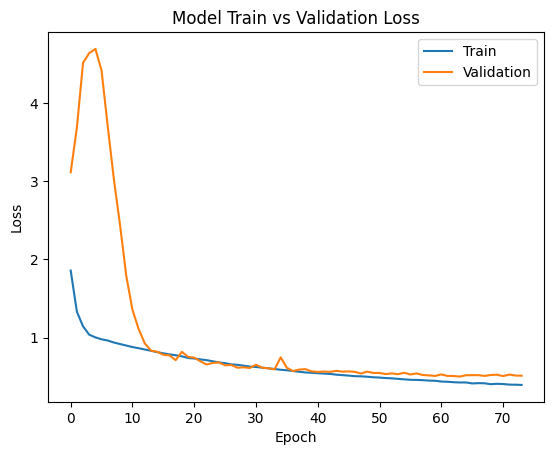

In [ ]:
# Plot showing the performance of the model to better visualise the model's learning.

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Train vs Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [ ]:
# Loading the weights from file so we don't have to call model.fit every time.
model.load_weights("weights.h5")

313/313 [==============================] - 1s 3ms/step


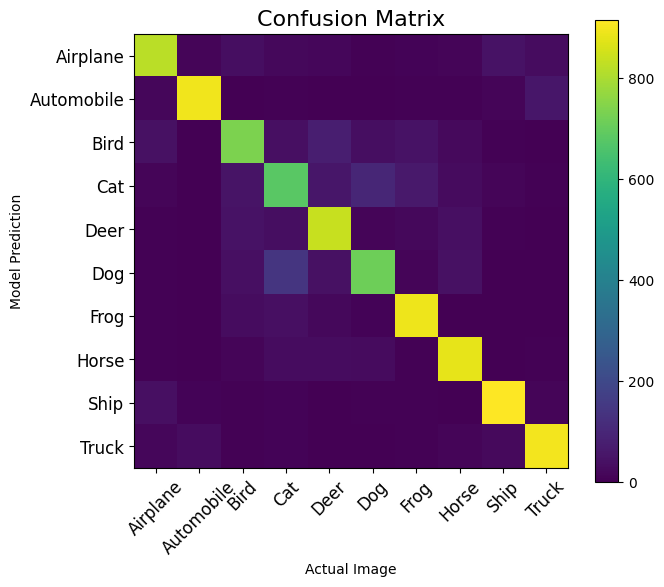

Model Accuracy: 82.71%


In [ ]:
# make test predictions
y_pred_test = model.predict(x_test)
y_pred_test_classes = np.argmax(y_pred_test, axis=1)
y_pred_test_max_probas = np.max(y_pred_test, axis=1)
y_test_index = [list(onehot).index(1) for onehot in y_test]

# confusion matrix and accuracy. Added axes labels for better understanding.
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
plt.figure(figsize=(7, 6))
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel("Actual Image")
plt.ylabel("Model Prediction")
plt.imshow(confusion_matrix(y_test_index, y_pred_test_classes))
plt.xticks(np.arange(10), cifar10_classes, rotation=45, fontsize=12)
plt.yticks(np.arange(10), cifar10_classes, fontsize=12)
plt.colorbar()
plt.show()
accuracy = accuracy_score(y_test_index, y_pred_test_classes) * 100
print(f'Model Accuracy: {accuracy:.2f}%')


## As we can see above, the model has an overall accuracy of 82.71%. It is very strong in identifying trucks, ships, horses, frogs and automobiles as can be seen by the yellow colour.

## It struggles slightly when identifying airplanes and deer and struggles most with identifying dogs, birds and cats as is indicated by the more green blocks.


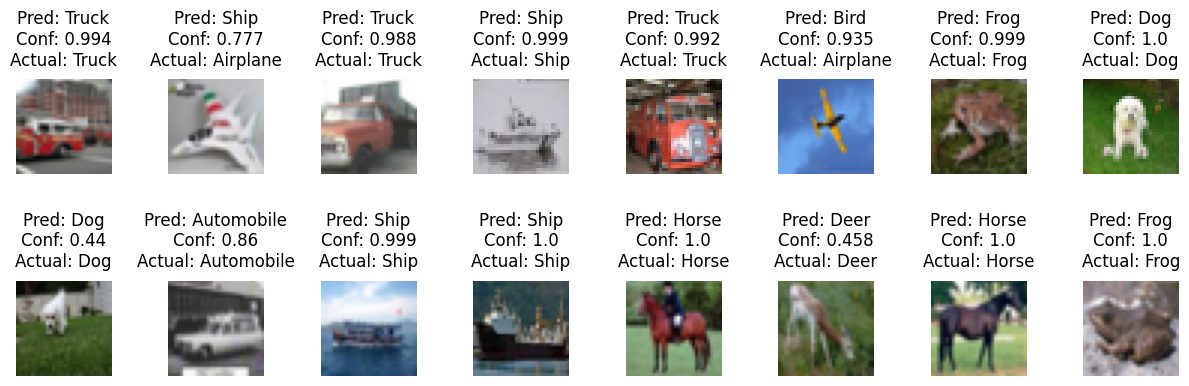

In [ ]:
# inspect preditions
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 3 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_test))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_test[random_index, :])
        pred_label = cifar10_classes[y_pred_test_classes[random_index]]
        pred_proba = y_pred_test_max_probas[random_index]
        true_label = cifar10_classes[y_test_index[random_index]]
        ax.set_title("Pred: {}\nConf: {:.3}\nActual: {}".format(
               pred_label, pred_proba, true_label
        ), pad=10)
plt.subplots_adjust(wspace=0.6, hspace=0.1)
plt.show()

## As we can see above, the model correctly identifies 14 out of 16 of the image subjects, which, in this case is an 87.5% accuracy.
## Confirming the confusion matrix, the model is very good at identifying trucks, frogs, and horses and all of these predictions have a confidence (conf) of more than 98%.

## The model did fail to identify the one airplane as it thought it was a ship, but to be fair it could be a SPACEship. It also failed to identify the other airplane and thought it was a bird, but I mean, it has wings.

#Bonus

In [ ]:
# This section of code produces a classification report in order to better analyse the results.

# Explanation of output:
# Precision tells us the accuracy of positive predictions.
# Recall shows how many of the actual positives were captured through labeling.
# The F1 score is the weighted average of Precision and Recall.
# The support is the number of actual occurrences of the class in the specified dataset.
# Accuracy indicates the overall effectiveness of the model across all classes.
# Macro Average averages the metric scores (precision, recall, F1-score) for all classes.
# Weighted Average averages the metric scores (precision, recall, F1-score) for all classes,
# weighting each class by its support (the number of true instances for each class). This accounts for class imbalance.
# These descriptions were sourced from ChatGPT.

print(classification_report(y_test_index, y_pred_test_classes, target_names=cifar10_classes))

              precision    recall  f1-score   support

    Airplane       0.85      0.82      0.83      1000
  Automobile       0.94      0.90      0.92      1000
        Bird       0.77      0.74      0.75      1000
         Cat       0.68      0.68      0.68      1000
        Deer       0.77      0.84      0.80      1000
         Dog       0.79      0.71      0.75      1000
        Frog       0.84      0.89      0.86      1000
       Horse       0.85      0.88      0.86      1000
        Ship       0.90      0.92      0.91      1000
       Truck       0.89      0.90      0.89      1000

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.83      0.83      0.83     10000



## As can be seen from the classification report, the model is best at identifying automobiles (94% accurate) and the least effective at identifying cats (68%). But, being right 68% of the time for your worst metric is quite impressive in my opinion. We can also see the overall average of 83% and an equal macro and weighted average suggesting there is no class imbalance.
## Overall, the model is strongest at predicting automobiles due to the higher F1 score for automobiles with ships following closely behind.

## If we examine the results in a deeper manner, we notice that the model is weaker at differentiating animals than objects. This is likely due to similar traits being present in living organisms, thereby challening the model more.

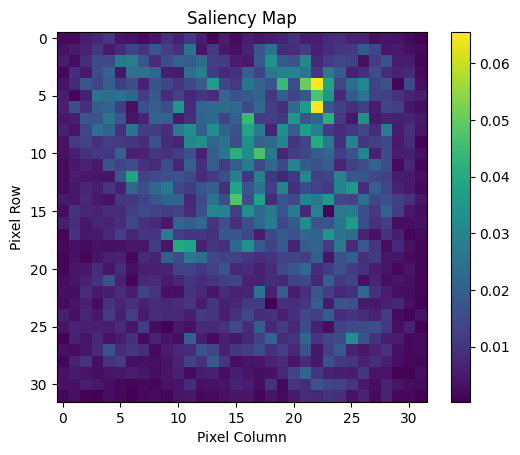

In [ ]:
# This section of code generates a saliency map for further analysis.
# A saliency map is a tool that allows us to visualize which parts of an input image influence the neural network's output.
# It highlights the areas of the image that are most important for predicting a particular class or outcome for our model.
# This technique was supported by help from ChatGPT.

def generate_saliency_map(model, image, class_idx):

    with tf.GradientTape() as tape:
        # Casting the image tensor to a float32.
        inputs = tf.cast(image[np.newaxis, ...], tf.float32)
        tape.watch(inputs)
        predictions = model(inputs)

        # Using class index to isolate the specific output for gradient calculation
        loss = predictions[:, class_idx]

    # Calculating the gradients of the loss with respect to the input image
    gradients = tape.gradient(loss, inputs)

    # Reducing across all axes except for the last one and taking the absolute value
    saliency = tf.reduce_max(tf.abs(gradients), axis=-1)[0]

    return saliency.numpy()

image_index = 0
class_index = np.argmax(y_test[image_index])

saliency_map = generate_saliency_map(model, x_test[image_index], class_index)
plt.imshow(saliency_map, cmap='viridis')
plt.xlabel('Pixel Column')
plt.ylabel('Pixel Row')
plt.title('Saliency Map')
plt.colorbar()
plt.show()

## From the above saliency map we can see the most integral areas of the image in our model's decision making process (the yelow pixels). Clearly, the pixels located closer to the centre have a larger impact than those around the edges of the image.  

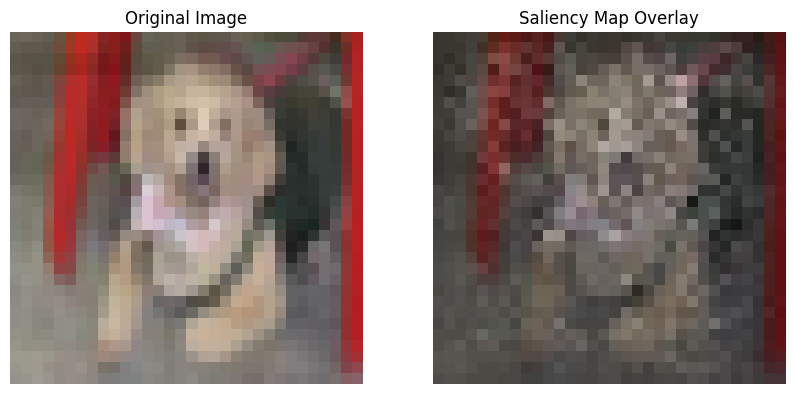

In [ ]:
# Superimposing our saliency map on one of our test images.

# Normalizing the saliency map for better visualization
saliency_map_normalized = saliency_map / np.max(saliency_map)

# Confirming the original image is in the correct shape (32x32x3) and type.
if x_train[random_index, :].max() > 1:
    x_train[random_index, :] = x_train[random_index, :].astype('float') / 255

# Creating the overlay of the saliency map on the original image.
alpha = 0.5  # Making the overlay more transparent.
overlay = (1 - alpha) * x_train[random_index, :] + alpha * saliency_map_normalized[:, :, np.newaxis]

# Plotting the original image and overlay

plt.figure(figsize=(10, 5))

# Plotting the original image for comparison
plt.subplot(1, 2, 1)
plt.imshow(x_train[random_index, :]) # Random image out of the data set
plt.title('Original Image')
plt.axis('off')  # Hiding the axis labels and ticks

# Plotting the overlay
plt.subplot(1, 2, 2)
plt.imshow(overlay)
plt.title('Saliency Map Overlay')
plt.axis('off')

plt.show()

## In the above example we can see that our model analyses the central pixels most in its decision making process rather than those around the edges.

## Overall we have managed to create a succesful model that is capable of identifying the subject of an image to a high degree of accuracy and I think we should be proud of him/her, even though he/she gets confused from time to time.